#  N1 Health 
Food Access Projects

__________________________
For transparency, my 4ish hours started here... I will be clear about when I kept going (even though I was over my expected time limit)

In [55]:
# ~~~~~~~~~~ Import Data and packages ~~~~~~~~~~ #
##packages
import pandas as pd
import sqlite3
import math
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

##connect database
filePath = "C:\\Users\\augus\\OneDrive\\Documents\\August\\IAA\\Spring I\\n1healthdatachallenge\\challenge.db\\"
conn = sqlite3.connect(filePath + 'challenge.db')

##import data
five_hundred_cities = pd.read_sql_query("SELECT * FROM five_hundred_cities", conn)
access = pd.read_sql_query("SELECT * FROM access", conn)
variable_list = pd.read_sql_query("SELECT * FROM variable_list", conn)

##Close Database
conn.commit()
conn.close()

##Spatial data to use for visuals
filePath2 = "C:\\Users\\augus\\OneDrive\\Documents\\August\\IAA\\Spring I\\n1healthdatachallenge\\"
tract_boundaries = gpd.read_file(filePath2 + "500Cities_Tracts_Clip.shp")

In [56]:
# ~~~~~~~~~~ Data Eploration ~~~~~~~~~~ #
## five_hundred_cities
five_hundred_cities.head(3)
    # Notable Variables
        # Basics: StateAbbr, PlaceName, Tract#
        # Potentially related variables: OBESITY, physical health, sleep, teeth lost, physical activity, stroke, mental health
            # Given as percentages of a population?
        # Worth looking at all variables for identifying unlikely correlations
access.head(3)
    # Use this as a quick visualization tool: 
    # https://www.ers.usda.gov/data-products/food-environment-atlas/go-to-the-atlas
variable_list.head(3)
    # List of most notable variable in this dataset
        # ... most of these variables don't exist in our data...
        # 2015 only (for now)
            # Use 2010-2015 change for further narrowing down


notableVariables = ['LACCESS_POP15','PCT_LACCESS_POP15','LACCESS_LOWI15','PCT_LACCESS_LOWI15','LACCESS_HHNV15','PCT_LACCESS_HHNV15','LACCESS_CHILD15','PCT_LACCESS_CHILD15','LACCESS_SENIORS15','PCT_LACCESS_SENIORS15','GROC16','GROCPTH16','SNAPS17','WICS16','SNAPSPTH17','WICSPTH16','PCT_SNAP17','PC_SNAPBEN17','SNAP_PART_RATE16','FOOD_BANKS18','FOODINSEC_15_17','VLFOODSEC_15_17','POVRATE15','CHILDPOVRATE15'] #Oops, most of these don't exist
notableVariables_Low = ['GROC16','GROCPTH16','FOOD_BANKS18'] # none of these are actually in the dataset
notableVariables_High = ['LACCESS_LOWI15','PCT_LACCESS_LOWI15','LACCESS_HHNV15','PCT_LACCESS_HHNV15'] # High values in these variable is notable for needing additonal food program assistance
    # Variables not included for further analysis... Race Demographics...
        # These should potentially get incorporated depending on business context
        # Potential further steps: Feature engineer a single variable that combine demographics that weight minority demographics proportionally.

First Round of Evaluation (LACCESS county data only)

In [57]:
# ~~~~~~~~~~~ Data Setup ~~~~~~~~~~~~~ #
### Preparing County Eval ... Population & Population PCT ...for... LowIncome + NoVehicle + SNAP Population + Children&Seniors ... 2015 only
##Creating datasets of important variables based on use
access_base = access[['FIPS','State','County']]
access_improving = access[['PCH_LACCESS_LOWI_10_15','PCH_LACCESS_HHNV_10_15']]
access_improving['POP_LACCESS_LOWI_10_15'] = access['LACCESS_LOWI15'] - access['LACCESS_LOWI10'] # population change improvement
notableVariables = ['LACCESS_LOWI15','PCT_LACCESS_LOWI15','LACCESS_HHNV15','PCT_LACCESS_HHNV15','LACCESS_SNAP15','PCT_LACCESS_SNAP15']
access_ = access[notableVariables]

## Children + Seniors ... Feature Engineering
access_['LACCESS_CHILD+SENIORS_10'] = access['LACCESS_CHILD10'] + access['LACCESS_SENIORS10']
access_['LACCESS_CHILD+SENIORS_15'] = access['LACCESS_CHILD15'] + access['LACCESS_SENIORS15']
    # Creating a variable for Children + Seniors Percent Change, add this to access_improving data
access_improving['PCH_LACCESS_CHILD+SENIORS_10_15'] = (100 * (access_['LACCESS_CHILD+SENIORS_15'] - access_['LACCESS_CHILD+SENIORS_10'])) / access_['LACCESS_CHILD+SENIORS_10']
access_.drop(['LACCESS_CHILD+SENIORS_10'], axis=1,  inplace=True) # not including 2010 stats
    # Children + Seniors Percent
access_['PCT_LACCESS_CHILD+SENIORS_15'] = access['PCT_LACCESS_CHILD15'] + access['PCT_LACCESS_SENIORS15'] #Is it appropriate to add the percentages? Check back in later...

## Scaling Variables from 0 to 1
scaler = MinMaxScaler()
access_scale = access_.copy()
notableVariables_scale = ['LACCESS_LOWI15','PCT_LACCESS_LOWI15','LACCESS_HHNV15','PCT_LACCESS_HHNV15','LACCESS_SNAP15','PCT_LACCESS_SNAP15','LACCESS_CHILD+SENIORS_15','PCT_LACCESS_CHILD+SENIORS_15'] #same as notable variables, with 'child + seniors' variables added
access_scale[notableVariables_scale] = scaler.fit_transform(access_scale[notableVariables_scale])

    #Average these variables together for identifying an aggregated greatest need
access_scale['aggregateNotableVariables_LACCESS'] = access_scale[notableVariables_scale].mean(axis=1).astype('float')

    #merge datasets... name / FIPS / Improvement Stats
access_scale = pd.concat([access_base,access_scale,access_improving], axis=1)
access_['aggregateNotableVariables_LACCESS'] = access_scale['aggregateNotableVariables_LACCESS']
access_ = pd.concat([access_base,access_,access_improving], axis=1)

C:\Users\augus\AppData\Local\Temp\ipykernel_21700\608237281.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_improving['POP_LACCESS_LOWI_10_15'] = access['LACCESS_LOWI15'] - access['LACCESS_LOWI10'] # population change improvement
C:\Users\augus\AppData\Local\Temp\ipykernel_21700\608237281.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  access_['LACCESS_CHILD+SENIORS_10'] = access['LACCESS_CHILD10'] + access['LACCESS_SENIORS10']
C:\Users\augus\AppData\Local\Temp\ipykernel_21700\608237281.py:1

In [58]:
# ~~~~~~~~~~ Evaluating Top Need Counties ~~~~~~~~~~ #

## Evaluating the scaled and aggregated Low Food Access Variable... Looking at 2010 to 2015 changes too
access_scale.sort_values('aggregateNotableVariables_LACCESS', ascending=False).head(10) # viewing for initial evaluation
    # Reflection:
        # Cities in the top 10 fall into 2 main categories:
            # High Population LI (ie: TX, CA)
            # High Percentage LI (ie: AK, SD)
        # Ideal City to choose has moderately high both... and has gotten worse from 2010-2015

access_.sort_values('aggregateNotableVariables_LACCESS', ascending=False).head(10)
    # Top Choice:
        # Maricopa, AZ
            # 170k LI_LACCESS (4.4%)... 20% worse than 2010
            # 14k NV LACCESS (2.3%)
            # 19k SNAP LACCESS (1.3%)
        # But where specifically?

## Printing of top 10 counties to evaluate for food programs 
access_.sort_values('aggregateNotableVariables_LACCESS', ascending=False).head(10)
## altering the data for better presentation
access_view = access_[['County', 'State', 'aggregateNotableVariables_LACCESS', 'LACCESS_LOWI15', 'PCT_LACCESS_LOWI15', 'PCH_LACCESS_LOWI_10_15', 'POP_LACCESS_LOWI_10_15']].sort_values('aggregateNotableVariables_LACCESS', ascending=False).head(10) # selecting less variables for better presenting
num_cols = access_view.select_dtypes(include=['number']).columns
for col in num_cols:
    if 'PCT' in col or 'PCH' in col or 'agg' in col:
        access_view[col] = access_view[col].round(2)  # Round PCT columns to 2 decimal places
    else:
        access_view[col] = access_view[col].round(0).astype(int)  # Round other numeric columns to 0 decimal places
access_view.sort_values('aggregateNotableVariables_LACCESS', ascending=False)

,County,State,aggregateNotableVariables_LACCESS,LACCESS_LOWI15,PCT_LACCESS_LOWI15,PCH_LACCESS_LOWI_10_15,POP_LACCESS_LOWI_10_15
2623,Harris,TX,0.53,259480,6.34,-11.30,-33062
2537,Bexar,TX,0.44,182902,10.67,-8.07,-16046
103,Maricopa,AZ,0.41,167933,4.40,19.96,27945
95,Yukon-Koyukuk,AK,0.41,2780,49.75,-0.68,-19
2630,Hidalgo,TX,0.40,164641,21.25,-19.97,-41070
92,Wade Hampton,AK,0.40,3121,41.84,-5.12,-168
2369,Buffalo,SD,0.39,1374,71.84,519.48,1152
70,Bethel,AK,0.39,7143,41.99,8.86,581
2579,Dallas,TX,0.36,165056,6.97,-12.76,-24135
2417,Shannon,SD,0.36,8438,62.11,65.80,3349


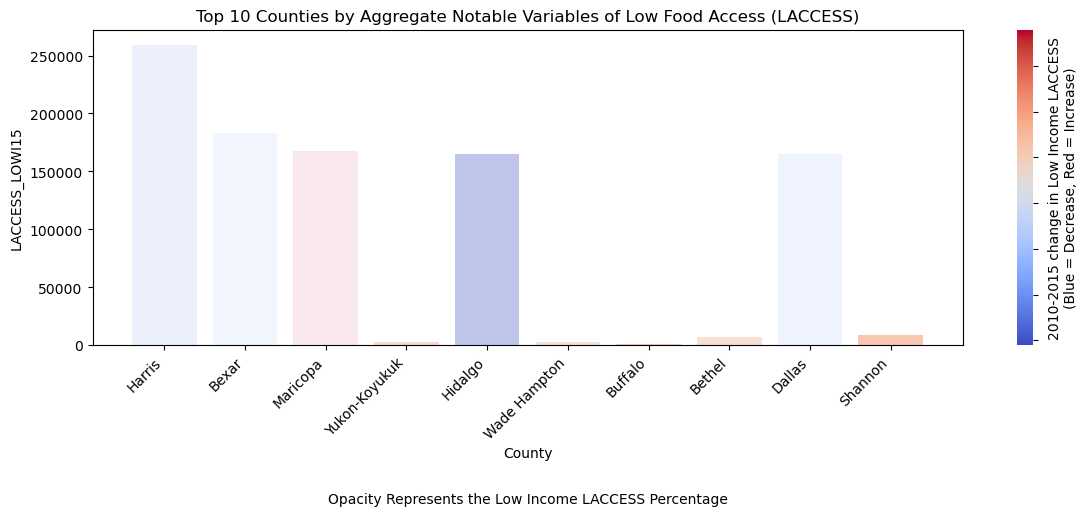

In [70]:
## ~~~~~~~~~~~ Visualizing the counties by need ~~~~~~~~~~~ ## 
    # How to visually show the tradeoff between population size and population percentage?

## Plot food access need country-wide
# Merge .shp file for visualizing
tract_boundaries['county_FIPS'] = tract_boundaries['plctract10'].str[8:13].astype('int')
access_ = access_.rename(columns={'FIPS':'county_FIPS'})
access_visualize = tract_boundaries.merge(access_, on="county_FIPS", how="left")
access_visualize_USmainland = access_visualize[~access_visualize['State'].isin(['AK', 'HI'])] #trying to make this visual more recognizable, it's hard to see

### Plotting US counties
    # Terminal visual was too zoomed out, let's find an alternative
"""
# Graph the agreggated Health Factors variable
columnCheck = "aggregateNotableVariables_LACCESS"
access_visualize_USmainland.plot(column=columnCheck, cmap="coolwarm", legend=True, figsize=(10, 10))
plt.title("Health Concerns in Maricopa, AZ")
plt.show()
"""

### Using a web-based map to navigate and compare US counties
    # This map is better for visualizing the US cities, but it's still dificult to navigate.
"""
# Convert to Web
import folium
access_visualize = access_visualize.rename(columns={"tract2010": "TractFIPS"})
access_visualize = access_visualize.to_crs(epsg=4326)

# Initialize a folium map
m = folium.Map(location=[40, -100], zoom_start=5)  # Adjust zoom_start for better fit

# Feed variables for color
folium.Choropleth(
    geo_data=access_visualize,
    data=access_visualize,
    columns=["county_FIPS", "aggregateNotableVariables_LACCESS"],
    key_on="feature.properties.county_FIPS",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name="Food Assistance Need",
).add_to(m)
m.save("FoodAssistanceNeed.html")
print("file 'FoodAssistanceNeed.html' is being saved to the same location as this file. Please see the first visual")
"""

# Bar chart to visualize (LI population / LI percentage / LI improvement)
top_10 = access_.sort_values('aggregateNotableVariables_LACCESS', ascending=False).head(10)


import matplotlib.pyplot as plt
import numpy as np

# Sort the data by 'aggregateNotableVariables_LACCESS'
top_10 = access_.sort_values('aggregateNotableVariables_LACCESS', ascending=False).head(10)

# Normalize values for color and opacity
color_norm = plt.Normalize(top_10['POP_LACCESS_LOWI_10_15'].min(), top_10['POP_LACCESS_LOWI_10_15'].max())
opacity_norm = plt.Normalize(top_10['PCT_LACCESS_LOWI15'].min(), top_10['PCT_LACCESS_LOWI15'].max() * 1.1) # ensuring a little opacity in every bar

# Get the normalized colors and opacities
colors = plt.cm.coolwarm(color_norm(top_10['POP_LACCESS_LOWI_10_15']))
opacities = opacity_norm(top_10['PCT_LACCESS_LOWI15'])

# Create the bar chart
plt.figure(figsize=(12, 6))

# Plot each bar with varying height, color, and opacity
for i, (county, height, color, opacity) in enumerate(zip(
        top_10['County'], 
        top_10['LACCESS_LOWI15'], 
        colors, 
        opacities)):
    plt.bar(county, height, color=color, alpha=opacity + 0.09)  # Ensure a minimum opacity with '+ 0.09'

# Add labels and title
plt.xticks(rotation=45, ha='right')  # Rotate county labels for better readability
plt.xlabel('County')
plt.ylabel('LACCESS_LOWI15')
plt.title('Top 10 Counties by Aggregate Notable Variables of Low Food Access (LACCESS)')


# Add a colorbar for 'POPCH_LACCESS_LOWI_10_15'
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=color_norm)  
sm.set_array([])  
cbar = plt.colorbar(sm, ax=plt.gca())  
cbar.ax.set_yticklabels([])  # Remove the numbers from the color legend  
cbar.ax.patch.set_alpha(0.5)  # Set the color legend opacity to 0.5  
cbar.ax.set_ylabel('2010-2015 change in Low Income LACCESS\n(Blue = Decrease, Red = Increase)', rotation=90, labelpad=15, va='center', alpha=1.0)  # Keep text at full opacity  






cbar.outline.set_visible(False)  

plt.text(0.5, -0.5, "Opacity Represents the Low Income LACCESS Percentage",  
         transform=plt.gca().transAxes, fontsize=10, rotation=0, ha='center')

# Show the plot
plt.tight_layout()
plt.show()



Incorporating Health Factors on a more granular level

C:\Users\augus\AppData\Local\Temp\ipykernel_21700\2372207844.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Phoenix_healthFactors['ACCESS2_CrudePrev_Pop'] = Phoenix_healthFactors['Population2010'] * Phoenix_healthFactors['ACCESS2_CrudePrev'] / 100  # otherwise it would be percentages... population is better metric
C:\Users\augus\AppData\Local\Temp\ipykernel_21700\2372207844.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Phoenix_healthFactors['TractFIPS'] = Phoenix_healthFactors['TractFIPS'].astype

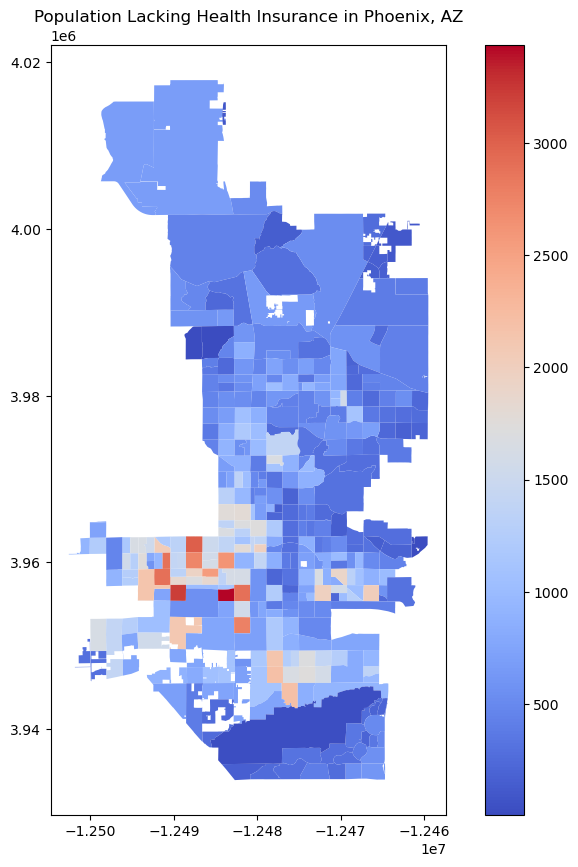

Top 3


,TractFIPS,ACCESS2_CrudePrev_Pop,Population2010,ACCESS2_CrudePrev
949,4013112602,3435.855,7935,43.3
939,4013112505,3213.696,8369,38.4
886,4013109400,3017.560,8290,36.4


In [60]:
# ~~~~~~~~~~~~ Initial Vizualization of Population in Maricopa, AZ Lacking Health Insurance  ~~~~~~~~~~~~ #
## Filter to Maricopa, AZ == 'Phoenix'
Phoenix_healthFactors = five_hundred_cities[(five_hundred_cities['StateAbbr'] == 'AZ') & (five_hundred_cities['PlaceName'] == 'Phoenix')]
Phoenix_healthFactors['ACCESS2_CrudePrev_Pop'] = Phoenix_healthFactors['Population2010'] * Phoenix_healthFactors['ACCESS2_CrudePrev'] / 100  # otherwise it would be percentages... population is better metric

#Joining tractFIPS with .shp file
tract_boundaries = tract_boundaries.rename(columns={"tract2010": "TractFIPS"})
tract_boundaries['TractFIPS'] = tract_boundaries['TractFIPS'].astype(int)
Phoenix_healthFactors['TractFIPS'] = Phoenix_healthFactors['TractFIPS'].astype(int)
tract_boundaries_merged = tract_boundaries.merge(Phoenix_healthFactors, on="TractFIPS", how="inner")

columnCheck = "ACCESS2_CrudePrev_Pop"  # Can replace with other variables for a quick check
tract_boundaries_merged.plot(column=columnCheck, cmap="coolwarm", legend=True, figsize=(10, 10))
plt.title("Population Lacking Health Insurance in Phoenix, AZ")
plt.show()

## I thought viewing on the web map was helpful for context
"""
# Initialize a folium map
m = folium.Map(location=[33.4484, -112.0740], zoom_start=10)

# Feed variables for color
folium.Choropleth(
    geo_data=tract_boundaries_merged,
    data=tract_boundaries_merged,
    columns=["TractFIPS", "ACCESS2_CrudePrev_Pop"],
    key_on="feature.properties.TractFIPS",
    fill_color="YlOrRd",
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name="Population of Health Concern factors",
).add_to(m)
m.save("Phoenix_HealthConcerns.html")
print("file 'Phoenix_HealthConcerns.html' is being saved to the same location as this file.")
"""


# Top 3 locations by # people lacking health insurance
print('Top 3')
Phoenix_healthFactors[['TractFIPS','ACCESS2_CrudePrev_Pop','Population2010','ACCESS2_CrudePrev']].sort_values('ACCESS2_CrudePrev_Pop', ascending=False).head(3)


C:\Users\augus\AppData\Local\Temp\ipykernel_21700\3294583532.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Phoenix_healthFactors['aggregate_healthFactors'] = Phoenix_healthFactors_scale['aggregate_healthFactors']


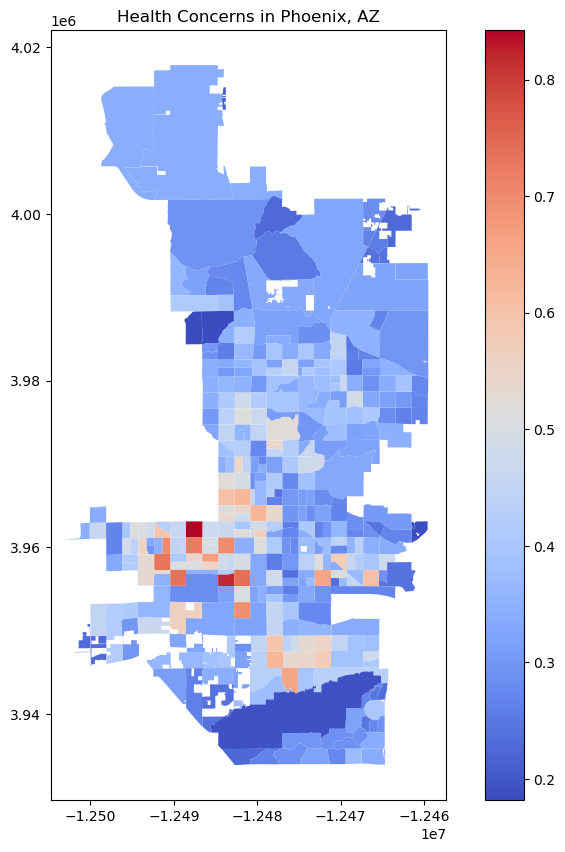

New Top 3


,TractFIPS,aggregate_healthFactors,Population2010
886,4013109400,0.842546,8290
949,4013112602,0.819452,7935
950,4013112700,0.736995,6740


In [61]:
## ~~~~~~~~~~ Deeper Health Analysis of Phoenix, AZ ~~~~~~~~~~ ##
    # Lack of Health Insurance Enough?
        # See the map above for checking. Let's compare this to an arbitrary agregate
Phoenix_Base = Phoenix_healthFactors[['StateAbbr','PlaceName', 'PlaceFIPS','TractFIPS','Population2010']]
notableHealthVariables = ['ACCESS2_CrudePrev', 'BPHIGH_CrudePrev', 'CHD_CrudePrev','CHECKUP_CrudePrev','DENTAL_CrudePrev','DIABETES_CrudePrev','HIGHCHOL_CrudePrev','MHLTH_CrudePrev','OBESITY_CrudePrev','SLEEP_CrudePrev','TEETHLOST_CrudePrev']

# Seperate between low/high, then scale and aggregate again...
notableHealthVariables_high = ['ACCESS2_CrudePrev', 'BPHIGH_CrudePrev', 'CHD_CrudePrev','DIABETES_CrudePrev','HIGHCHOL_CrudePrev','MHLTH_CrudePrev','OBESITY_CrudePrev','SLEEP_CrudePrev','TEETHLOST_CrudePrev'] # High in these means more in need of food program
notableHealthVariables_low = ['CHECKUP_CrudePrev','DENTAL_CrudePrev'] # Low in these means more in need of food program

# Convert Percentage variables to population estimates
Phoenix_healthFactors_scale = Phoenix_healthFactors[notableHealthVariables].apply(lambda col: (col * Phoenix_healthFactors['Population2010'].astype('float')) / 100, axis=0)

# Scale these variables 0 to 1
scaler = MinMaxScaler()
Phoenix_healthFactors_scale[notableHealthVariables_low] = 1 - scaler.fit_transform(Phoenix_healthFactors_scale[notableHealthVariables_low])
Phoenix_healthFactors_scale[notableHealthVariables_high] = scaler.fit_transform(Phoenix_healthFactors_scale[notableHealthVariables_high])

# Sum these variables together for identifying greatest need
Phoenix_healthFactors_scale['aggregate_healthFactors'] = Phoenix_healthFactors_scale[notableHealthVariables].mean(axis=1).astype('float')

# merge back name / FIPS / Improvement Stats
Phoenix_healthFactors_scale = pd.concat([Phoenix_Base,Phoenix_healthFactors_scale], axis=1)
Phoenix_healthFactors['aggregate_healthFactors'] = Phoenix_healthFactors_scale['aggregate_healthFactors']

# Graph the agreggated Health Factors variable
columnCheck = "aggregate_healthFactors"
merged_data = tract_boundaries.merge(Phoenix_healthFactors, on="TractFIPS", how="inner")
merged_data.plot(column=columnCheck, cmap="coolwarm", legend=True, figsize=(10, 10))
plt.title("Health Concerns in Phoenix, AZ")
plt.show()

print('New Top 3')
Phoenix_healthFactors[['TractFIPS','aggregate_healthFactors','Population2010']].sort_values('aggregate_healthFactors', ascending=False).head(3)

In [69]:
## ~~~~~~~~~~ Research on Top 2 Areas in Phoenix, AZ ~~~~~~~~~~~ #

# Carl Hayden HS (Dark-Red District in middle... FIPS 4013112602):
    # https://www.usnews.com/education/best-high-schools/arizona/districts/phoenix-union-high-school-district/carl-hayden-high-school-1051
    # 2,200 students
    # "The total minority enrollment is 99%, and 93% of students are economically disadvantaged"
    # 72% graduation rate (top 500 worst in the nation)

# Maryvale High School (Dork-Red District in upper-left middle... FIPS 4013109400)
    # https://www.usnews.com/education/best-high-schools/arizona/districts/phoenix-union-high-school-district/maryvale-high-school-1053
    # 2,800 students
    # "The total minority enrollment is 98%, and 88% of students are economically disadvantaged"
    # 72% graduation rate

# There are a couple food pantries already in the area.
    # Potential next steps: Talk to these food pantrie about how their needs and how they can be more supported.

print("Maryvale HS (upper-middle-left... TractFIPS 47157008800) has a high school with 2,800 students, over 2,400 economically disadvantaged","\n",
      "I could identify multiple food pantries currently in the area, more research should be done to identify best support measures.","\n",
      "with 8,300 people and 36.4% lacking health insurance... that is 3,000 people")


Maryvale HS (upper-middle-left... TractFIPS 47157008800) has a high school with 2,800 students, over 2,400 economically disadvantaged 
 I could identify multiple food pantries currently in the area, more research should be done to identify best support measures. 
 with 8,300 people and 36.4% lacking health insurance... that is 3,000 people


My answer... Maryvale district in Maricopa, AZ (Phoenix)... which has the potential to support 3,000 people with better food access

This was the end of my 4 hours... 
______________________________________

But I was also curious about what clustering might look like for this data

## Testing a Cluster Approach

In [63]:
## ~~~~~~~~~~~~~ Data Setup for clustering based on LACCESS and Health variables ~~~~~~~~~~~~~~~ ##

### Filter, Scales, and Combine datasets
scaler = MinMaxScaler()    #Scale these variables 0 to 1

    #500 Cities data
five_hundred_cities_base = five_hundred_cities[['StateAbbr','PlaceName','TractFIPS']]
five_hundred_cities_base['county_FIPS'] = five_hundred_cities['Place_TractID'].str[8:13].astype('int')

notableHealthVariables_cluser2010 = ['ACCESS2_CrudePrev', 'BPHIGH_CrudePrev', 'CHD_CrudePrev','CHECKUP_CrudePrev','DENTAL_CrudePrev','DIABETES_CrudePrev','HIGHCHOL_CrudePrev','MHLTH_CrudePrev','OBESITY_CrudePrev','SLEEP_CrudePrev','TEETHLOST_CrudePrev'] #11 total variables here
five_hundred_cities_cluster_percent = five_hundred_cities[notableHealthVariables_cluser2010]
#five_hundred_cities_cluster_percent[notableHealthVariables_cluser2010] = scaler.fit_transform(five_hundred_cities_cluster_percent[notableHealthVariables_cluser2010])

five_hundred_cities_cluster_pop = five_hundred_cities[notableHealthVariables_cluser2010].apply(lambda col: (col * five_hundred_cities['Population2010'].astype('float')) / 100, axis=0)
#five_hundred_cities_cluster_pop[notableHealthVariables_cluser2010] = scaler.fit_transform(five_hundred_cities_cluster_pop[notableHealthVariables_cluser2010])

five_hundred_cities_cluster = pd.concat([five_hundred_cities_base,five_hundred_cities_cluster_percent,five_hundred_cities_cluster_pop], axis=1)

    # access dataset
access_base = access[['County','FIPS']]
access_base = access_base.rename(columns={'FIPS':'county_FIPS'})
notableAccessVariables_cluster2010 = ['LACCESS_POP10','PCT_LACCESS_POP10','LACCESS_LOWI10','PCT_LACCESS_LOWI10','LACCESS_HHNV10','PCT_LACCESS_HHNV10','LACCESS_CHILD10','PCT_LACCESS_CHILD10','LACCESS_SENIORS10','PCT_LACCESS_SENIORS10'] #10 TOTAL
access_cluster = access[notableAccessVariables_cluster2010]
#access_cluster[notableAccessVariables_cluster2010] = scaler.fit_transform(access_cluster[notableAccessVariables_cluster2010]) * 2.2  # twice as important as health factors (half as many of these variables)
access_cluster = pd.concat([access_base,access_cluster], axis=1)

## Merge Datasets
access_Health_cluster = five_hundred_cities_cluster.merge(access_cluster, on='county_FIPS' , how='left')
access_Health_cluster.dropna(inplace=True)


C:\Users\augus\AppData\Local\Temp\ipykernel_21700\3055003424.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_hundred_cities_base['county_FIPS'] = five_hundred_cities['Place_TractID'].str[8:13].astype('int')


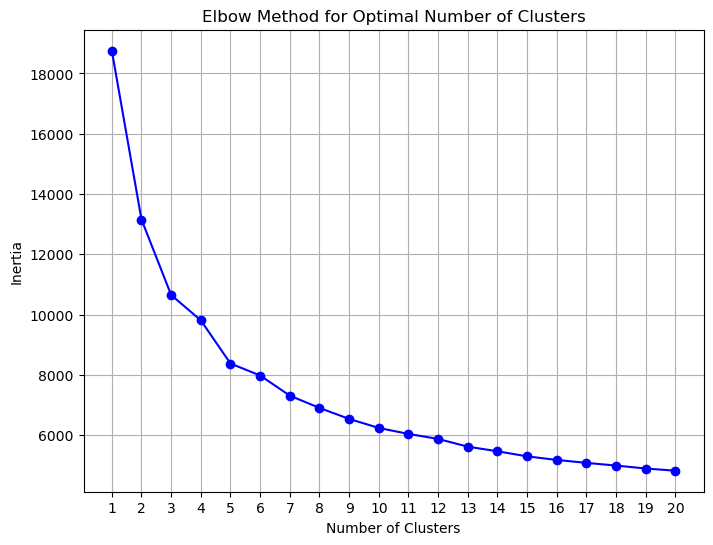

In [64]:
## ~~~~~~~~~~~~ Determining Ideal number of Clusters ~~~~~~~~~~~~ ##
# Select the relevant columns for clustering
X = access_Health_cluster.drop(['StateAbbr', 'PlaceName','County','county_FIPS','TractFIPS'], axis=1, inplace=False)

scaler = MinMaxScaler() # Standardize again because 500 cities cut out a lot of extremes in the county access data
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.loc[:,21:] = X_scaled.loc[:,21:] #* math.sqrt(2) # should access variables equally weighted to the health variables?

# Elbow Method to determine the ideal number of clusters
inertia = []  # List to store the inertia (sum of squared distances to centroids)
max_k = 20  # Choose an appropriate max number of clusters to test

# Calculate KMeans for different numbers of clusters (1 to max_k)
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Add the inertia (distortion) to the list

# Plot the Elbow Chart
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k + 1), inertia, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

#best option?
kmeans = KMeans(n_clusters=5, random_state=42)

C:\Users\augus\AppData\Local\Temp\ipykernel_21700\3388001466.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


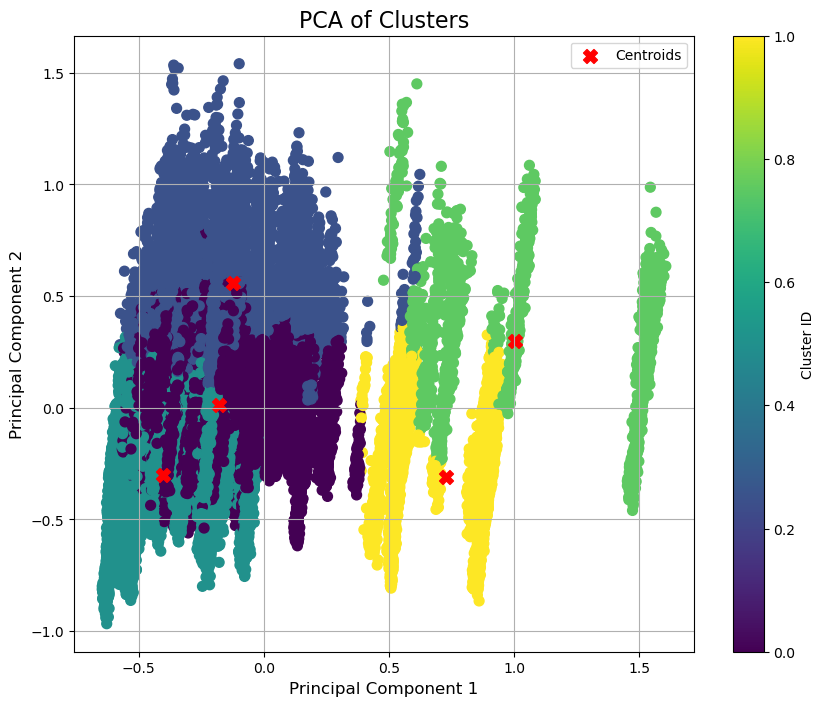

In [65]:
## ~~~~~~~~~~ Visualizing Cluster Results ~~~~~~~~~~ ##
# Fit KMeans with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
access_Health_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

## General PCA for visualizing
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
access_Health_cluster['PCA1'] = pca_components[:, 0]
access_Health_cluster['PCA2'] = pca_components[:, 1]

# Plot the clusters and centroids
plt.figure(figsize=(10, 8))
plt.scatter(access_Health_cluster['PCA1'], access_Health_cluster['PCA2'], 
            c=access_Health_cluster['Cluster'], cmap='viridis', s=50)
plt.title('PCA of Clusters', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(loc='upper right')
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', color='red', s=100, label='Centroids')

# Show color bar and legend
plt.colorbar(label='Cluster ID')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Reflection
    # It appears that lots of the districts within a county are highly clustered together (this makes sense, all of their county data is the same)
    # Potential Future Steps: configure estimates for Low Income LACCESS on a district wide level.
    # Cluster aggregated data with less variables, opposed to many variables that create lots of noise.


In [ ]:
## ~~~~~~~~~~ Analyzing Cluster Results ~~~~~~~~~~ ##

## Questions I am curious about
    # Which cluster has the highest LI_LACCESS ?
access_Health_clusterGroups = access_Health_cluster.groupby('Cluster')[['LACCESS_POP10','LACCESS_LOWI10','PCT_LACCESS_LOWI10','ACCESS2_CrudePrev','MHLTH_CrudePrev']].mean().sort_values('LACCESS_POP10')
access_Health_clusterGroups['Num_Counties'] = access_Health_cluster.groupby('Cluster').size()
access_Health_clusterGroups
        #Clusters 2:        Smaller populations,            No distinction between health concerns or food access 
        #Clusters 1 & 0:    Medium populations,             similar food access, high vs low health concerns respectively
        #Clusters 4 & 3:    larger populations,             low need vs high need respectively

    # Which clusters improved the most from 2010 - 2015?
access_Improve = pd.DataFrame()
access_Improve['Mean_LACCESS_PCH']  = access[['PCH_LACCESS_POP_10_15','PCH_LACCESS_LOWI_10_15','PCH_LACCESS_HHNV_10_15','LACCESS_CHILD_10_15','PCH_LACCESS_SENIORS_10_15']].mean(axis=1)
access_Improve['county_FIPS'] = access['FIPS']
access_Health_cluster_Improve = access_Health_cluster.merge(access_Improve,on='county_FIPS',how='left')
access_Health_clusterGroups_Improve = access_Health_cluster_Improve.groupby('Cluster')[['LACCESS_POP10','LACCESS_LOWI10','PCT_LACCESS_LOWI10','ACCESS2_CrudePrev','MHLTH_CrudePrev','Mean_LACCESS_PCH']].mean().sort_values('LACCESS_POP10')
access_Health_clusterGroups_Improve['Num_Counties'] = access_Health_cluster_Improve.groupby('Cluster').size()
access_Health_clusterGroups_Improve
    #Generally, all populations improved except for the large populations with low need
    #Cluster 1 improved the least of all the high need groups

,LACCESS_POP10,LACCESS_LOWI10,PCT_LACCESS_LOWI10,ACCESS2_CrudePrev,ACCESS2_CrudePrev,MHLTH_CrudePrev,MHLTH_CrudePrev,Mean_LACCESS_PCH,Num_Counties
Cluster,,,,,,,,,
2,73058.137274,15066.154568,1.644340,14.407458,593.905589,12.853487,519.377113,-11.389702,7428
1,148512.624572,41642.050219,7.124271,23.958364,809.803652,18.404654,600.443696,-3.102211,5243
0,148933.898411,37171.324567,6.886892,12.821392,476.245145,12.484512,457.700184,-4.192556,7961
4,514231.238631,123439.735266,2.645462,15.699363,625.131690,12.763382,504.727658,3.010227,4394
3,607416.989915,210353.097627,8.711928,29.300053,1281.960648,14.746748,641.588217,-11.316793,1891


In [67]:
#What cluster were given to the 3 main locations in Maricopa, AZ?
access_Health_cluster_Phoenix = access_Health_cluster[(access_Health_cluster['County'] == 'Maricopa') & (access_Health_cluster['StateAbbr'] == 'AZ')]
access_Health_cluster_Phoenix_main3 = access_Health_cluster[(access_Health_cluster['TractFIPS'] == 4013112602) | (access_Health_cluster['TractFIPS'] == 4013112505) | (access_Health_cluster['TractFIPS'] == 4013109400)]
access_Improve = pd.DataFrame()
access_Improve['Mean_LACCESS_PCH']  = access[['PCH_LACCESS_POP_10_15','PCH_LACCESS_LOWI_10_15','PCH_LACCESS_HHNV_10_15','LACCESS_CHILD_10_15','PCH_LACCESS_SENIORS_10_15']].mean(axis=1)
access_Improve['county_FIPS'] = access['FIPS']
access_Health_cluster_Phoenix_main3_Improve = access_Health_cluster_Phoenix_main3.merge(access_Improve,on='county_FIPS',how='left')
access_Health_cluster_Phoenix_main3_Improve[['StateAbbr','PlaceName', 'TractFIPS','county_FIPS', 'Cluster']]
    #All 3 of the main locations in Maricopa, AZ belong to cluster 3 (medium populaiton, high need)... 

# Kmeans reflection... There will need to be a lot more clusters to get the granularity of focusing on speicific areas

## Potential Next Steps
# Perhaps KNN would be better for this if we can identify areas of need. Perhaps by using changes in health factors as a target variable...

,StateAbbr,PlaceName,TractFIPS,county_FIPS,Cluster
0,AZ,Phoenix,4013109400,4013,3
1,AZ,Phoenix,4013112505,4013,3
2,AZ,Phoenix,4013112602,4013,3
